In [276]:
from scipy import linalg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
plt.style.use('seaborn-ticks')
%matplotlib inline
%cd ...

C:\Users\Maruda\Documents\dataScienceWNE\pythonMLDS


Lets pick up where we left.

In [375]:
medical = pd.read_pickle("data/medical.p")

In [3]:
# The file includes socio-demographic data, including 
# health insurance and various aspects of health care
# touchpoints for the respondent group of a survey
# conducted in the USA.

# The collection includes 35072 observations and 27 variables:
  
# UMARSTAT – Marital status recode
# UCUREMP – Currently has employer coverage
# UCURNINS – Currently uninsured
# USATMED – Satisfied with quality of medical care
# URELATE – Number of relatives in household
# REGION – region
# STATE - state
# HHID – Household identification number
# FHOSP – In hospital overnight last year
# FDENT – Dental visits last year
# FEMER – Number of emergency room visits last year
# FDOCT – Number of doctor visits last year
# UIMMSTAT – Immigration status
# U_USBORN – U.S.- or foreign-born
# UAGE – Age topcoded
# U_FTPT – Full-time or part-time worker this year
# U_WKSLY – Weeks worked last year
# U_HRSLY – Hours worked per week last year
# U_USHRS – Hours worked per week this year
# HEARNVAL – Earnings amount last year - Household
# HOTHVAL – Household income, total exc. earnings
# HRETVAL – Retirement amount – Household
# HSSVAL – Social Security amount - Household
# HWSVAL – Wages and salaries amount – Household
# UBRACE – race
# GENDER – gender
# UEDUC3 – education level
# CEYES - color of eyes
# CHAIR - color of hair

First we will recode UCURNINS to binary form.

In [376]:
print(medical.UCURNINS.unique())
medical["UCURNINS"] = (medical.UCURNINS=="Yes").astype(int)
print(medical.UCURNINS.unique())

['Yes' 'No']
[1 0]


Today we will work with sklearn a lot. Therefore we need to recode all variables with nominal levels to binary form. We will use pandas get_dummies method for that. Lets just get rid of HHID

In [377]:
levCols = []
numCols = []
numUniqs = 0

for col in medical.columns:
    if medical[col].dtype==object:
        levCols.append(col)
        if col != "HHID" :
            numUniqs = numUniqs + len(medical[col].unique())
    else:
        numCols.append(col)
levCols.remove("HHID") # Household identification number.
print(f'Sum of unique categories: %s' %(numUniqs))

Sum of unique categories: 88


In [378]:
# Change categoricals into dummies.
dummLev = pd.get_dummies(medical[levCols])
dummLev.shape

(35072, 88)

In [379]:
medical = pd.concat([medical[numCols], dummLev], axis=1)

In [380]:
# For desperados: https://scikit-learn.org/stable/auto_examples/classification/...
# ...plot_lda_qda.html#sphx-glr-auto-examples-classification-plot-lda-qda-py
# Colormap
cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)
plt.cm.register_cmap(cmap=cmap)

# Plot functions
def plot_data(lda, X, y, y_pred, fig_index) :
    
    splot = plt.subplot(2, 2, fig_index)
    
    if fig_index == 1:
        plt.title("Linear Discriminant Analysis")
    elif fig_index == 2:
        plt.title("Quadratic Discriminant Analysis")
    
    plt.ylabel(X.columns[1])
    plt.xlabel(X.columns[0])
    tp = y == y_pred  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[X0_tp.columns[0]], X0_tp[X0_tp.columns[1]], marker=".", color="red")
    plt.scatter(X0_fp[X0_fp.columns[0]], X0_fp[X0_fp.columns[1]], marker="x", s=20, color="#990000")  # dark red

    # class 1: dots
    plt.scatter(X1_tp[X1_tp.columns[0]], X1_tp[X1_tp.columns[1]], marker=".", color="blue")
    plt.scatter(X1_fp[X1_fp.columns[0]], X1_fp[X1_fp.columns[1]], marker="x", s=20, color="#000099")  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(
        xx, yy, Z, cmap="Accent", norm=colors.Normalize(0.0, 1.0), zorder=0
    )
    plt.contour(xx, yy, Z, [0.5], linewidths=2.0, colors="white")

    # means
    plt.plot(
        lda.means_[0][0],
        lda.means_[0][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )
    plt.plot(
        lda.means_[1][0],
        lda.means_[1][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(
        mean,
        2 * v[0] ** 0.5,
        2 * v[1] ** 0.5,
        180 + angle,
        facecolor=color,
        edgecolor="black",
        linewidth=2,
    )
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, "red")
    plot_ellipse(splot, lda.means_[1], lda.covariance_, "blue")


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], "red")
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], "blue")


In [381]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html

           U_WKSLY      UAGE  UCURNINS
U_WKSLY   1.000000  0.168092 -0.138103
UAGE      0.168092  1.000000 -0.142746
UCURNINS -0.138103 -0.142746  1.000000

Percent of True for UCURNINS is 14.444571167883211

LinearDiscriminantAnalysis prediction quality is:
85.30451642335767
QuadraticDiscriminantAnalysis prediction quality is:
83.49110401459853


<ipython-input-380-c7905f9da92d>:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(
<ipython-input-380-c7905f9da92d>:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(


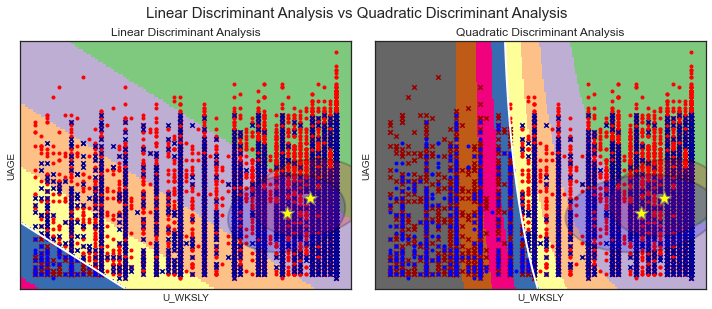

In [382]:
# Let's play a bit with just 2 explaining variables...
features = ['U_WKSLY', 'UAGE', 'UCURNINS'] # The last one is explained one.
print(medical[features].corr()) # Correlations
print(f'\nPercent of True for %s is %s\n' %(features[-1], 100 * medical[features[-1]].sum() / len(medical)))

plt.figure(figsize=(10, 8), facecolor="white")
plt.suptitle(
    "Linear Discriminant Analysis vs Quadratic Discriminant Analysis",
    y=0.98,
    fontsize=15,
)

lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
est = lda.fit(medical[features[:2]], medical[features[-1]])
preds = est.predict(medical[features[:2]])
print('LinearDiscriminantAnalysis prediction quality is:')
print(100 * est.score(medical[features[:2]], medical[features[-1]], sample_weight = None)) # Accuracy.

splot = plot_data(lda, medical[features[:2]], medical[features[-1]], preds, fig_index=1)
plot_lda_cov(lda, splot)
plt.axis("tight")

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
est1 = qda.fit(medical[features[:2]], medical[features[-1]])
preds1 = est1.predict(medical[features[:2]])
print('QuadraticDiscriminantAnalysis prediction quality is:')
print(100 * est1.score(medical[features[:2]], medical[features[-1]], sample_weight = None)) # Accuracy.

splot = plot_data(qda, medical[features[:2]], medical[features[-1]], preds1, fig_index=2)
plot_qda_cov(qda, splot)
plt.axis("tight")


plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [383]:
features = medical.columns.tolist() # We are gonna to work only on these vars!!!
features.remove("UCURNINS")

In [384]:
# We try to predict a status of a person: insured or not.
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
est = lda.fit(medical[features], medical["UCURNINS"])
preds = est.predict(medical[features])
probs = est.predict_proba(medical[features])
sum(preds == medical["UCURNINS"]) / len(preds) # Accuracy.

0.8959568886861314

In [385]:
# What does it mean, such accuracy?
print(sum(preds) / len(preds))
print(sum(medical["UCURNINS"]) / len(medical))
# Our wonderful model predicts that (almost) EVERYONE is insured!

0.2454664689781022
0.1444457116788321


In [386]:
# We see that prediction cover both states
print(probs[0])
print(sum(probs[0]))

[0.10135147 0.89864853]
1.0


In [387]:
# Let's use different initial probabilities.
medical.groupby("UCURNINS")["UCURNINS"].count() / len(medical)

UCURNINS
0    0.855554
1    0.144446
Name: UCURNINS, dtype: float64

In [388]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True, priors=(0.5, 0.5))
est = lda.fit(medical[features], medical["UCURNINS"])
preds1 = est.predict(medical[features])
probs1 = est.predict_proba(medical[features])
sum(preds1 == medical["UCURNINS"])/len(preds)

0.8908245894160584

In [389]:
pd.crosstab(preds, preds1)

col_0      0     1
row_0             
0      26179   284
1          0  8609

In [390]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
est = qda.fit(medical[features], medical["UCURNINS"])
preds2 = est.predict(medical[features])
probs2 = est.predict_proba(medical[features])
sum(preds2 == medical["UCURNINS"])/len(preds2)

C:\Users\Maruda\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.8907390510948905

In [391]:
# Let's find which variables are colinear.
# What about model's parameters associated with these vars?
import numpy as np
corrs = medical[numCols].corr().abs() # Why are we using only numerical columns here?
temp = corrs.unstack()
temp = temp.sort_values(kind = "quicksort")
temp = temp[(temp > 0.8) & (temp < 1)] # Why do we use less than 1 here?
temp.reset_index(level = 1, drop = True)

U_HRSLY     0.889031
U_USHRS     0.889031
HEARNVAL    0.951602
HWSVAL      0.951602
dtype: float64

In [392]:
colsRemove = ['U_HRSLY', 'HEARNVAL']
features2 = list(features) # Why do we use this?
features2.remove('U_HRSLY')
features2.remove('HEARNVAL')

In [394]:
# So, what's the impact of using a bit different set of variables when they are collinear?
qda = QuadraticDiscriminantAnalysis(store_covariance=True, priors=(0.5, 0.5))
est = qda.fit(medical[features2], medical["UCURNINS"])
preds3 = est.predict(medical[features2])
probs3 = est.predict_proba(medical[features2])
sum(preds3 == medical["UCURNINS"])/len(preds3)

C:\Users\Maruda\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.8907390510948905

In [297]:
pd.crosstab(preds, preds3)

col_0      0     1
row_0             
0      26174   289
1          2  8607

In [395]:
# Let's see if a person is satisfied with quality of medical care...
features = medical.columns.tolist()
features.remove("USATMED")

In [396]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
est = lda.fit(medical[features], medical["USATMED"])
preds = est.predict(medical[features])
probs = est.predict_proba(medical[features])
sum(preds == medical["USATMED"])/len(preds)

0.5165374087591241

In [404]:
# What does it mean, such accuracy?
print(medical.groupby('USATMED')["USATMED"].count() / len(medical))
[print(x, '  ', sum(preds == x) / len(preds)) for x in sorted(medical["USATMED"].unique())]
# Model predicts that typical patient is very satisfied, and gets 50% of accuracy.
# Just assuming 'very satisfied' you get the same accuracy!

USATMED
0    0.031107
1    0.070427
2    0.024892
3    0.360287
4    0.513287
Name: USATMED, dtype: float64
0    0.002480611313868613
1    0.0002281021897810219
2    0.01993042883211679
3    0.11701642335766424
4    0.8603444343065694


[None, None, None, None, None]

In [407]:
pd.crosstab(medical["USATMED"], preds)

col_0     0  1    2     3      4
USATMED                         
0        21  0   32   217    821
1        10  4   51   389   2016
2         4  0  159   160    550
3        28  2  221  1765  10620
4        24  2  236  1573  16167

In [397]:
lda =  QuadraticDiscriminantAnalysis(store_covariance=True)
est = lda.fit(medical[features], medical["USATMED"])
preds1 = est.predict(medical[features])
probs1 = est.predict_proba(medical[features])
est.score(medical[features], medical["USATMED"], sample_weight = None)

C:\Users\Maruda\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.03592609489051095

In [405]:
# What does it mean, such accuracy?
print(medical.groupby('USATMED')["USATMED"].count() / len(medical))
[print(x, '  ', sum(preds1 == x) / len(preds1)) for x in sorted(medical["USATMED"].unique())]
# Totally flawed!!!

USATMED
0    0.031107
1    0.070427
2    0.024892
3    0.360287
4    0.513287
Name: USATMED, dtype: float64
0    0.9734260948905109
1    0.015824589416058393
2    0.0007983576642335766
3    0.009893932481751825
4    5.702554744525547e-05


[None, None, None, None, None]

In [406]:
pd.crosstab(medical["USATMED"], preds1)

col_0        0    1   2    3  4
USATMED                        
0         1082    7   1    1  0
1         2411   49   1    9  0
2          844   15   2   12  0
3        12298  201  10  126  1
4        17505  283  14  199  1

In [ ]:

#--------------------------------------------------------------------
# Exercises 3.

# Exercise 3.1.

# Titanic passengers data – 1310 observations and 15 variables:

# passenger_id – Unique passenger id
# pclass – Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
# survived – Survival (0 = No, 1 = Yes)
# name – Name and SUrname
# sex – Sex (0 = Male, 1 = Female)
# age – Age in years
# sibsp – # of siblings / spouses aboard the Titanic
# parch – # of parents / children aboard the Titanic
# ticket – Ticket number
# fare – Passenger fare
# cabin – Cabin number
# embarked – Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
# boat – Lifeboat (if survived)
# body – Body number (if did not survive and body was recovered)
# home.dest – Home/Destination

# Use linear and quadratic discriminant analysis to
# explain the probability of survival (survived = 1).
# Generate fitted values and compare them for different
# models.








In [ ]:

# Exercise 3.2.
# Wine Quality Data Set: "data/wines.csv"
# source: https://archive.ics.uci.edu/ml/datasets/wine+quality
# The file contains data on samples of white and red Portuguese wine 
# Vinho Verde. 
# Various physico-chemical characteristics of individual samples
# are available as well as wine quality scores on a point scale (0-10) 
# made by specialists.

# Perform linear and quadratic discriminant analysis 
# to model the quality of wine (variable quality),
# treating the explained variable as qualitative.
# Generate fitted values and compare them for different models.

